# Lab 4

## JMuBEN2 dataset


(https://data.mendeley.com/datasets/tgv3zb82nd/1)

Image dataset taken from an Arabica coffee plantation. The image dataset contains collection of healthy and miner coffee leaves.

# Loading and Spliting the dataset 

In [1]:
import os
import requests
import zipfile
import numpy as np

dataset_url = 'https://github.com/ishaqmarashy/DATALFS/raw/main/JMuBEN.zip'
dataset_dir = './JMuBEN'

# create directory for dataset if it does not exist
if not os.path.exists(dataset_dir):
    os.makedirs(dataset_dir)
    
# append JMuBEN.zip to the end of the path (this is where we download the file to)
zip_file_path = os.path.join(dataset_dir, 'JMuBEN.zip')


# check if file is downloaded already
if not os.path.exists(zip_file_path):
    
    # file is not downloaded so fetch the file
    response = requests.get(dataset_url)
    
    # write file to storage which is recieved from the response
    with open(zip_file_path, 'wb') as zip_file:
        zip_file.write(response.content)
        
    # unzip to zip file path
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(dataset_dir)

# within the concat train and test to become ./JMuBEN/train and JMuBEN ./JMuBEN/test
train_dir = os.path.join(dataset_dir, 'train')
test_dir = os.path.join(dataset_dir, 'test')

In [2]:
def load_images_and_labels(directory):
    images = []
    labels = []
    
    # get subdirectories Healthy and Miner
    
    for class_name in os.listdir(directory):
        
        # concat subdirectory to get full path
        class_dir = os.path.join(directory, class_name)
        # assign labels using class subdirectory
        # label is determined by filepath
        label = 0 if class_name == 'Miner' else 1
        
        # append labels and image paths to labels and images respectively
        for filename in os.listdir(class_dir):
            images.append(os.path.join(class_dir, filename))
            labels.append(label)
            
    return images, labels

# load file directories and their labels
train_images_dir, train_labels = load_images_and_labels(train_dir)
test_images_dir, test_labels = load_images_and_labels(test_dir)

In [3]:
# print the number of images and labels

print(f"Train images:{len(train_images_dir)}  Labels:{len(train_labels)}")
print(f"Test images:{len(test_images_dir)}  Labels:{len(test_labels)}")


Train images:24000  Labels:24000
Test images:6000  Labels:6000


# Pre-processing and Normalization

Images in the dataset were converted to grayscale and resized to 128x128

Tried loading as described https://www.analyticsvidhya.com/blog/2021/07/step-by-step-guide-for-image-classification-on-custom-datasets/

https://towardsdatascience.com/pipelines-custom-transformers-in-scikit-learn-the-step-by-step-guide-with-python-code-4a7d9b068156

In [4]:
import cv2
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer

def load_grayscale_images(image_paths):
    loaded_images = []
    for image_path in image_paths:
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  #  grayscale
        loaded_images.append(img)
    return loaded_images

def resize_images(images_to_resize):
    resized_images = []
    for img in images_to_resize:
        resized_img = cv2.resize(img, (128, 128))  # resize
        resized_images.append(resized_img)
    return resized_images

def normalize_image(images_to_normalize):
    normalized_images = []
    for img in images_to_normalize:
        normalized_img = img / 255.0  # normalize
        normalized_images.append(normalized_img)
    return normalized_images

image_pipeline = Pipeline(steps=[
    ('load_grayscale_images', FunctionTransformer(load_grayscale_images)),
    ('resize_images', FunctionTransformer(resize_images)),
    ('normalize_image', FunctionTransformer(normalize_image))
])


train_images=image_pipeline.transform(train_images_dir)
test_images=image_pipeline.transform(test_images_dir)

In [5]:
print(len(train_images))
print(len(test_images))

24000
6000


# Model Training

## CNN Model

In [6]:
import pandas as pd
from sklearn.metrics import classification_report
import seaborn as sn; sn.set(font_scale=1.4)
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import tensorflow as tf
from tqdm import tqdm

from sklearn.model_selection import KFold

2023-10-12 15:04:22.400012: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [8]:
train_images[0]

array([[0.41960784, 0.39607843, 0.43137255, ..., 0.41960784, 0.40784314,
        0.43921569],
       [0.42745098, 0.38823529, 0.40392157, ..., 0.48235294, 0.4627451 ,
        0.48627451],
       [0.42745098, 0.38431373, 0.39607843, ..., 0.44313725, 0.39215686,
        0.38823529],
       ...,
       [0.49411765, 0.50588235, 0.5254902 , ..., 0.43921569, 0.47058824,
        0.46666667],
       [0.49803922, 0.46666667, 0.49019608, ..., 0.42745098, 0.45490196,
        0.4627451 ],
       [0.54901961, 0.45882353, 0.48627451, ..., 0.42352941, 0.43137255,
        0.45490196]])

In [9]:
from keras.optimizers import Adam 
EPOCHS = 6
IMG_WIDTH = 128
IMG_HEIGHT = 128
NUM_CATEGORIES = 2
TEST_SIZE = 0.2



model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3),padding='same', activation="relu", input_shape=(128, 128,1)),
   # tf.keras.layers.Conv2D(64, (3, 3), activation="relu"),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    
    tf.keras.layers.Conv2D(16, (3, 3),padding='same', activation="relu"),
   # tf.keras.layers.Conv2D(64, (3, 3), activation="relu"),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    
    #tf.keras.layers.Conv2D(64, (3, 3), activation="relu"),
    #tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    
   
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(8, activation="relu"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(NUM_CATEGORIES, activation="softmax")
])

model.compile(optimizer = Adam(0.0001), loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

history = model.fit(np.asarray(train_images, dtype=np.float32), np.asarray(train_labels), batch_size=128, epochs=50, validation_split=0.2, shuffle=True)


Epoch 1/50
150/150 [==============================] - 80s 531ms/step - loss: 0.6565 - accuracy: 0.6241 - val_loss: 0.8044 - val_accuracy: 0.0000e+00
Epoch 2/50
150/150 [==============================] - 80s 535ms/step - loss: 0.5848 - accuracy: 0.6919 - val_loss: 0.4338 - val_accuracy: 0.8671
Epoch 3/50
150/150 [==============================] - 78s 523ms/step - loss: 0.4833 - accuracy: 0.7956 - val_loss: 0.3517 - val_accuracy: 0.7871
Epoch 4/50
150/150 [==============================] - 79s 526ms/step - loss: 0.3980 - accuracy: 0.8643 - val_loss: 0.2372 - val_accuracy: 0.8740
Epoch 5/50
150/150 [==============================] - 79s 527ms/step - loss: 0.3511 - accuracy: 0.9002 - val_loss: 0.1954 - val_accuracy: 0.8969
Epoch 6/50
150/150 [==============================] - 79s 529ms/step - loss: 0.3215 - accuracy: 0.9195 - val_loss: 0.1241 - val_accuracy: 0.9423
Epoch 7/50
150/150 [==============================] - 80s 533ms/step - loss: 0.2985 - accuracy: 0.9293 - val_loss: 0.1145 - va

### Model Evaluation


In [10]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc

In [17]:
test_images = np.array(test_images)
test_images = test_images.reshape(-1, 128, 128, 1)

In [19]:
# evaluate how well the model did to predict the labels on the test images
score = model.evaluate(test_images, np.array(test_labels))
print(f'Test loss: {score[0]}/Test accuracy: {score[1]}')

188/188 [==============================] - 7s 38ms/step - loss: 0.0128 - accuracy: 0.9960
Test loss: 0.012762091122567654/Test accuracy: 0.9959999918937683


In [20]:
predict = model.predict(test_images)

188/188 [==============================] - 7s 37ms/step


In [27]:
# assign classes for high probabilities
predict_df = pd.DataFrame(predict)
class_predictions = predict_df.idxmax(axis=1)

In [28]:
accuracy = accuracy_score(test_labels, class_predictions)
print(f"Accuracy: {accuracy:.2f}")


Accuracy: 1.00


In [29]:
conf_matrix = confusion_matrix(test_labels, class_predictions)
conf_matrix

array([[2976,   24],
       [   0, 3000]])

In [30]:
precision = precision_score(test_labels, class_predictions)
precision

0.9920634920634921

In [31]:
# get precision, recall, f1-score values 
print(classification_report(test_labels, class_predictions))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00      3000
           1       0.99      1.00      1.00      3000

    accuracy                           1.00      6000
   macro avg       1.00      1.00      1.00      6000
weighted avg       1.00      1.00      1.00      6000



In [32]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(test_labels, predict[:, 1])

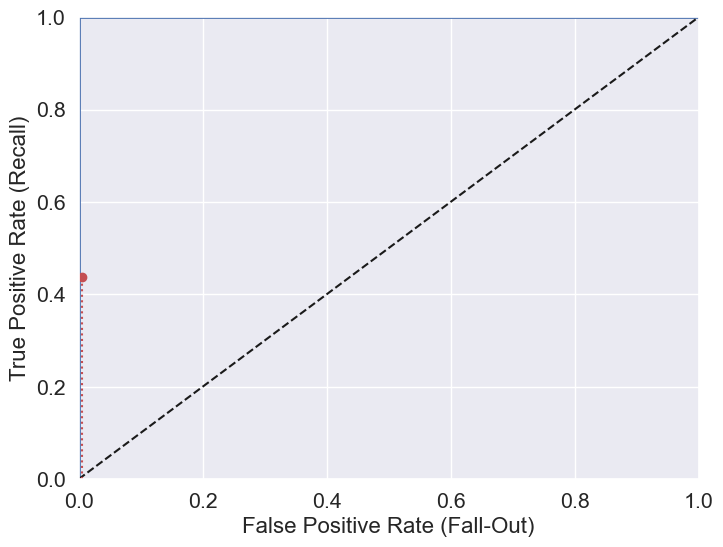

In [33]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([0, 1, 0, 1])                                    # Not shown in the book
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) # Not shown
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    # Not shown
    plt.grid(True)                                            # Not shown

plt.figure(figsize=(8, 6))                         # Not shown
plot_roc_curve(fpr, tpr)
plt.plot([4.837e-3, 4.837e-3], [0., 0.4368], "r:") # Not shown
plt.plot([0.0, 4.837e-3], [0.4368, 0.4368], "r:")  # Not shown
plt.plot([4.837e-3], [0.4368], "ro")               # Not shown
plt.show()

## SGD Classifier 

In [35]:
train_images = np.array(train_images)
train_images = train_images.reshape(train_images.shape[0], -1)

In [36]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)
sgd_clf.fit(train_images, train_labels)

SGDClassifier(random_state=42)

In [37]:
test_images = test_images.reshape(test_images.shape[0], -1)

In [38]:
sgd_clf.predict(test_images)

array([1, 1, 1, ..., 0, 0, 0])

### Model Evaluation

In [39]:
predictions = sgd_clf.predict(test_images)

In [40]:
from sklearn.metrics import accuracy_score

# accuracy
accuracy = accuracy_score(test_labels, predictions)
accuracy

0.8735

In [41]:
from sklearn.metrics import confusion_matrix

# confusion matrix
confusion_matrix = confusion_matrix(test_labels, predictions)
confusion_matrix

array([[2948,   52],
       [ 707, 2293]])

In [42]:
tp = confusion_matrix[0,0]
tn = confusion_matrix[1,1]
fp = confusion_matrix[1,0]
fn = confusion_matrix[0,1]

In [43]:
tp_rate = tp / (tp + fn)
tp_rate

0.9826666666666667

In [44]:
fp_rate = fp / (fp + tn)
fp_rate

0.23566666666666666

In [45]:
from sklearn.metrics import precision_score, recall_score, f1_score

In [46]:
precision_2 = precision_score(test_labels, predictions)
precision_2

0.9778251599147122

In [47]:
recall_2 = recall_score(test_labels, predictions)
recall_2

0.7643333333333333

In [48]:
f1 = f1_score(test_labels, predictions)
f1

0.85799812909261

In [49]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(test_labels, sgd_clf.decision_function(test_images))

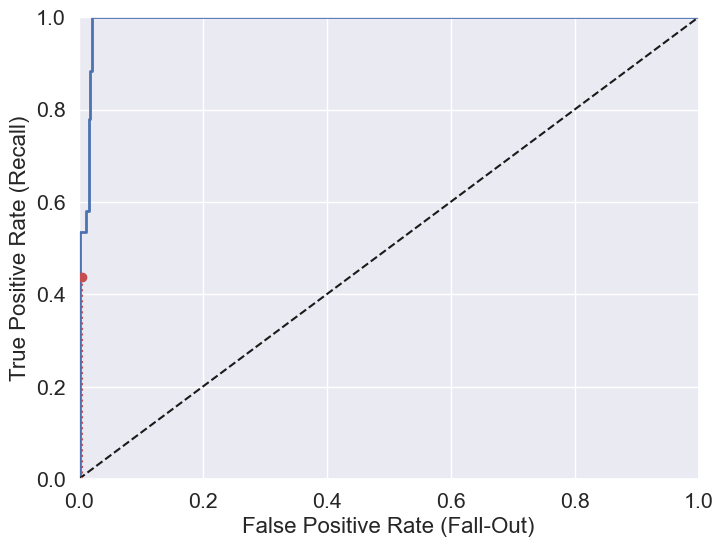

In [50]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([0, 1, 0, 1])                                    # Not shown in the book
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) # Not shown
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    # Not shown
    plt.grid(True)                                            # Not shown

plt.figure(figsize=(8, 6))                         # Not shown
plot_roc_curve(fpr, tpr)
plt.plot([4.837e-3, 4.837e-3], [0., 0.4368], "r:") # Not shown
plt.plot([0.0, 4.837e-3], [0.4368, 0.4368], "r:")  # Not shown
plt.plot([4.837e-3], [0.4368], "ro")               # Not shown
plt.show()